In [1]:
import pandas as pd
import numpy as np
import math
import scipy
from scipy.integrate import trapz,cumtrapz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy import signal
plt.style.use('seaborn')

In [2]:
df_linear = pd.read_csv('rotate2/globalAcce.csv',header=0,names=['acce','1','2','3'])
df_gyro = pd.read_csv('rotate2/Gyro.csv',header=0,names=['gyro','1','2','3'])
dt = 0.01 # for rotate
# dt = 0.02 # for nod

In [3]:
def signal_filter (X, Y, Z, Fs, cutoff1, cutoff2):
    Wn1 = 2*cutoff1/Fs
    Wn2 = 2*cutoff2/Fs
    b,a = signal.butter(1, [Wn1,Wn2], 'bandpass')
#     b,a = signal.butter(1,Wn1,'highpass')
    filteredX = signal.filtfilt(b, a, X)
    filteredY = signal.filtfilt(b, a, Y)
    filteredZ = signal.filtfilt(b, a, Z)
    return filteredX, filteredY, filteredZ

In [4]:
def threshould_detect(gyroX,gyroY,gyroZ):
    gyro_mag = np.sqrt(np.power(gyroX,2)+np.power(gyroY,2)+np.power(gyroY,2))
    # threshould detection
    stationary = gyro_mag < 0.02
    return stationary

In [5]:
def acceleration_integration(acceX, acceY, acceZ, stationary):
    v = np.zeros([len(acceX),3])
    for i in range (1, len(acceX)):
        v[i,0] = v[i-1,0]+(acceX[i-1]+acceX[i])*dt/2
        v[i,1] = v[i-1,1]+(acceX[i-1]+acceY[i])*dt/2
        v[i,2] = v[i-1,2]+(acceX[i-1]+acceZ[i])*dt/2
        if stationary[i] == True: v[i,:] = 0
    return v

In [6]:
def velocity_integration(velocityX, velocityY, velocityZ):
#     positionX = np.zeros(len(velocityX))
#     positionY = np.zeros(len(velocityX))
#     positionZ = np.zeros(len(velocityX))
#     for i in range (1, len(velocityX)):
#         positionX[i] = positionX[i-1] +(velocityX[i-1]+velocityX[i])*dt/2
#         positionY[i] = positionY[i-1] +(velocityY[i-1]+velocityY[i])*dt/2
#         positionZ[i] = positionZ[i-1] +(velocityZ[i-1]+velocityZ[i])*dt/2
    positionX = cumtrapz(velocityX, dx = dt)
    positionY = cumtrapz(velocityY, dx = dt)
    positionZ = cumtrapz(velocityZ, dx = dt)
    return positionX, positionY, positionZ

In [7]:
df_linear['filteredX'] = signal_filter(df_linear['1'],df_linear['2'],df_linear['3'],100, 0.1, 5)[0]
df_linear['filteredY'] = signal_filter(df_linear['1'],df_linear['2'],df_linear['3'],100, 0.1, 5)[1]
df_linear['filteredZ'] = signal_filter(df_linear['1'],df_linear['2'],df_linear['3'],100, 0.1, 5)[2]

/Users/yuki/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:189: UserWarning: When passing multiple axes, layout keyword is ignored
  warnings.warn(
/Users/yuki/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


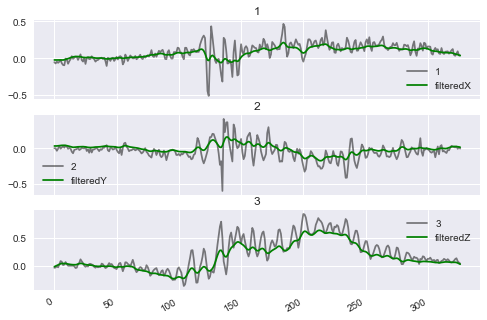

In [8]:
cols_raw = ['1','2','3']
cols_new = ['filteredX','filteredY','filteredZ']
rawplot = df_linear.plot(y=cols_raw,subplots=True,sharex=True,style='k',title=cols_raw,alpha=0.5)
df_linear.plot(y=cols_new,subplots=True,layout=(1,3),ax=rawplot,sharex=True,style='g')
plt.show()

In [9]:
stationary = threshould_detect(df_gyro['1'],df_gyro['2'],df_gyro['3'])
v = acceleration_integration(df_linear['filteredX'],df_linear['filteredY'],df_linear['filteredZ'], stationary)
# v = acceleration_integration(df_linear['1'],df_linear['2'],df_linear['3'], stationary)
velocityX = v[:,0]
velocityX = v[:,0]
velocityY = v[:,1]
velocityZ = v[:,2]

In [10]:
position = velocity_integration(velocityX, velocityY, velocityZ)
positionX = position[0]
positionY = position[1]
positionZ = position[2]

In [11]:
max(positionX)-min(positionX),max(positionY)-min(positionY),max(positionZ)-min(positionZ)

(0.0972656037121902, 0.04531466257203728, 0.11379580685083455)

In [12]:
def setQuiver(axes3d,x,y,z,deviceX,deviceY,deviceZ):
    distance = np.sqrt(math.pow(x[-1],2) + math.pow(y[-1],2) + math.pow(z[-1],2))
    l = 0.1 * distance
    axes3d.quiver(x[::50], y[::50], z[::50], deviceY[0][::50], deviceY[1][::50], deviceY[2][::50],
                  color = 'y',label = 'y', length = l)
    axes3d.quiver(x[::50], y[::50], z[::50], deviceX[0][::50], deviceX[1][::50], deviceX[2][::50],
                  color = 'b',label = 'x', length = l)
    axes3d.quiver(x[::50], y[::50], z[::50], deviceZ[0][::50], deviceZ[1][::50], deviceZ[2][::50],
                  color = 'g',label = 'z', length = l)
    axes3d.set_xlabel('X position (m)')
    axes3d.set_ylabel('Y position (m)')
    axes3d.set_zlabel('Z position (m)')
    axes3d.legend(fontsize= 15)

<IPython.core.display.Javascript object>


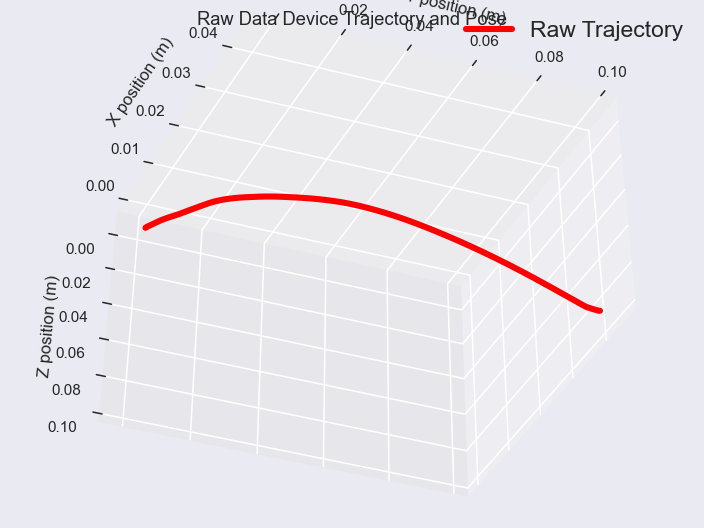

In [13]:
%matplotlib notebook
fig = plt.figure()
fig.suptitle('Raw Data Device Trajectory and Pose')
axes3d = Axes3D(fig)
axes3d.plot(positionX,positionY,positionZ,c='red',lw = 4, label = 'Raw Trajectory')
axes3d.set_xlabel('Y position (m)')
axes3d.set_ylabel('X position (m)')
axes3d.set_zlabel('Z position (m)')
axes3d.legend(fontsize= 15)
plt.show()

In [14]:
def curvature_helper(point1, point2, point3):
    temp1 = np.cross(point2-point1, point3-point1)
    length12 = np.linalg.norm(point1-point2)
    length13 = np.linalg.norm(point1-point3)
    temp2 = np.cross(temp1, point2-point1)
    temp3 = np.cross(temp1, point3-point1)
    temp4 = (math.pow(length13,2)*temp2-math.pow(length12,2)*temp3)/math.pow(np.linalg.norm(temp1),2)/2
    coordinate = point1 + temp4
    radius = np.linalg.norm(temp4)
    if radius == 0:
        direction = coordinate 
    else:
        direction = coordinate.T/math.pow(radius,2)
    return radius, coordinate, direction

In [15]:
def curvature(trajectory):
    row = trajectory.shape[0]
    column = trajectory.shape[1]
    l = np.zeros((row,1))
    radius = np.full([row,1], np.nan)
    coordinate = np.full([row,3], np.nan)
    direction = np.full([row,3], np.nan)
    for i in range (1,row-1):
        radius[i] = curvature_helper(trajectory[i,:].T, trajectory[i-1,:].T, trajectory[i+1,:].T)[0]
        coordinate[i,:] = curvature_helper(trajectory[i,:].T, trajectory[i-1,:].T, trajectory[i+1,:].T)[1]
        direction[i,:] = curvature_helper(trajectory[i,:].T, trajectory[i-1,:].T, trajectory[i+1,:].T)[2]
        l[i] = l[i-1] + np.linalg.norm(trajectory[i,:]-trajectory[i-1,:])
        
    l[row-1] = l[row-2] + np.linalg.norm(trajectory[row-1,:] - trajectory[row-2,:]) 
    return l, radius, coordinate, direction

In [16]:
trajectory = np.array([positionX, positionY, positionZ]).T
radius = curvature(trajectory)[1]

radius = radius[~np.isnan(radius)]
        
mean_radius = np.mean(radius)
print(mean_radius)

<ipython-input-14-2b1bf05eea59>:7: RuntimeWarning: invalid value encountered in true_divide
  temp4 = (math.pow(length13,2)*temp2-math.pow(length12,2)*temp3)/math.pow(np.linalg.norm(temp1),2)/2


0.19382232117827056
